which data sets are used?

1. no time adjustment ()
2. time adjustment to fit his el (_AEST)
3. his event log

read base xes files

In [14]:
import pm4py
import pandas as pd
from pytz import timezone

# read and combine all event logs
dfs = []
for i in range(1,6):
    log = pm4py.read_xes('base_xes_files/BPIC15_'+str(i)+'.xes')
    log.head()
    df = pm4py.convert_to_dataframe(log)
    df["r:municipality"] = f"muni-{i}"
    dfs.append(df)
combined_df = pd.concat(dfs, axis=0)


parsing log, completed traces ::   0%|          | 0/1199 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/832 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1409 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1053 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/1156 [00:00<?, ?it/s]

add australian time

AEST (Australian eastern standard time has no summer/winter time)


In [16]:
# change time back to Amsterdam because pm4py automatically converts to UTC
amsterdam_tz = timezone('Europe/Amsterdam')
combined_df['time:timestamp'] = combined_df['time:timestamp'].dt.tz_convert(
    amsterdam_tz)

# save to file
combined_df.to_csv("data/raw/bpic15.csv", index=False)

# change time to AEST (as in the paper) --> does not work (times are still off)
#aest_tz = timezone('Australia/Sydney')
#combined_df['time:timestamp'] = combined_df['time:timestamp'].dt.tz_convert(aest_tz)

# add 10 hours manually
aest_tz = timezone('UTC')
combined_df['time:timestamp'] = combined_df['time:timestamp'].dt.tz_convert(
    aest_tz)
combined_df['time:timestamp'] = combined_df['time:timestamp'].apply(lambda ts: ts + pd.Timedelta(hours=10))

# save to file
combined_df.to_csv("data/raw/bpic15_AEST.csv", index=False)

perform preprocessing steps


In [17]:
# Load raw data & Preprocess DataFrame (enrich with derived attributes)
logs = ['bpic15', 'bpic15_AEST']

for log in logs:
    fn = f'data/raw/{log}.csv'
    df = pd.read_csv(fn)[[
        'case:concept:name', 'activityNameEN', 'org:resource', 'time:timestamp',
        'case:last_phase', 'case:parts', 'action_code', 'r:municipality'
    ]]
    # Delete all rows were case_id = 4020737 --> Author response: "there is more than one value for attribute “ct:permit_type” 
    df = df[df['case:concept:name'] != 4020737]
    df = df.rename(columns={
        # Resource-related
        "activityNameEN": "activity label",
        # CT-related
        'case:last_phase': 'ct:last_phase',
        # AT-related
        "action_code": "concept:name",
        # Additional
        'case:parts': 'case_parts',
    })
    # TODO: derive 'ct:permit_type', 'at:phase' --> specified by the author
    df = df[~df['case_parts'].isna()]
    df['ct:permit_type'] = df.apply(lambda row: 'Bouw' if 'Bouw' in str(
        row['case_parts']).split(',') else 'Non Bouw', axis=1)

    # only look at the main subprocess: "01_HOOFD"
    df = df[~df['concept:name'].isna()]
    df = df[df['concept:name'].str.startswith('01_HOOFD')]
    df['at:phase'] = df['concept:name'].apply(lambda code: code[:10])

    # Universal (on Disco outputs)
    # derive and append TT related candidate attributes
    df['time:timestamp'] = pd.to_datetime(
        df['time:timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
    MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    df['tt:month'] = df['time:timestamp'].apply(lambda ts: MONTHS[ts.month-1])
    df['tt:day'] = df['time:timestamp'].apply(
        lambda ts: 'Day_{}'.format(ts.day))
    WEEKDAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    df['tt:weekday'] = df['time:timestamp'].apply(
        lambda ts: WEEKDAYS[ts.weekday()])
    df['tt:ampm'] = df['time:timestamp'].apply(
        lambda ts: 'AM' if ts.hour < 12 else 'PM')

    print(df)
    df.to_csv(f'data/processed/{log}.csv')

/var/folders/s_/tyyjfphn3wl93jz8bhkrh3x40000gn/T/ipykernel_85010/3091059455.py:6: DtypeWarning: Columns (21,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn)[[


        case:concept:name                    activity label  org:resource  \
0                10009138  register submission date request       9264148   
1                10009138              OLO messaging active       9264148   
2                10009138         send confirmation receipt       9264148   
5                10009138     create procedure confirmation       9264148   
6                10009138      create subcases completeness       9264148   
...                   ...                               ...           ...   
262621            9998898       read publication date field        560600   
262622            9998898     registration date publication        560600   
262623            9998898      stop all running subcases 2b        560600   
262624            9998898                phase case handled        560600   
262625            9998898       read publication date field        560600   

                   time:timestamp          ct:last_phase  \
0       2014-04

/var/folders/s_/tyyjfphn3wl93jz8bhkrh3x40000gn/T/ipykernel_85010/3091059455.py:6: DtypeWarning: Columns (21,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn)[[


        case:concept:name                    activity label  org:resource  \
0                10009138  register submission date request       9264148   
1                10009138              OLO messaging active       9264148   
2                10009138         send confirmation receipt       9264148   
5                10009138     create procedure confirmation       9264148   
6                10009138      create subcases completeness       9264148   
...                   ...                               ...           ...   
262621            9998898       read publication date field        560600   
262622            9998898     registration date publication        560600   
262623            9998898      stop all running subcases 2b        560600   
262624            9998898                phase case handled        560600   
262625            9998898       read publication date field        560600   

                  time:timestamp          ct:last_phase  \
0      2014-04-1

visualize time differences

[89137     0     0     0     0     0     0   455  7356 16224 17532 18103
 10110  7211  9088  8326  6882  1976   687   347    19]
21


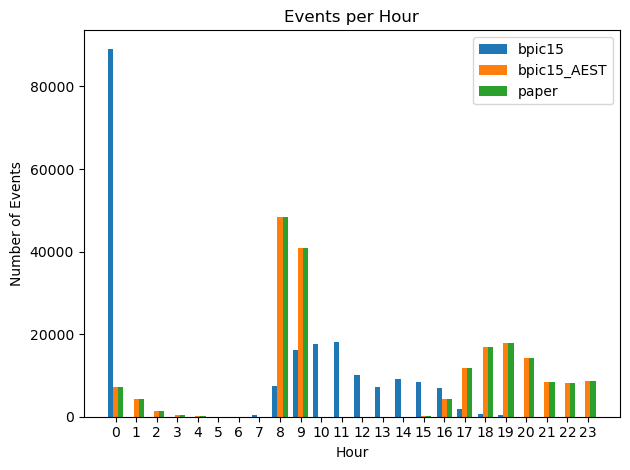

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Create the data
df_bpic15 = pd.read_csv('data/processed/bpic15.csv')
df_bpic15_AEST = pd.read_csv('data/processed/bpic15_AEST.csv')
df_paper = pd.read_csv('data/processed/bpic15_time_manipulated.csv')

# get hours
hours_bpic15 = df_bpic15['time:timestamp'].apply(lambda ts: ts[11:13])
hours_bpic15_AEST = df_bpic15_AEST['time:timestamp'].apply(lambda ts: ts[11:13])
hours_paper = df_paper['time:timestamp'].apply(lambda ts: ts[11:13])

# get counts
hours = np.arange(0, 24)
counts_df_bpic15 = np.bincount(hours_bpic15)
counts_df_bpic15_AEST = np.bincount(hours_bpic15_AEST)
counts_df_paper = np.bincount(hours_paper)

# Ensure that all counts arrays have the same length
max_len = max(len(counts_df_bpic15), len(
    counts_df_bpic15_AEST), len(counts_df_paper))
counts_df_bpic15 = np.pad(
    counts_df_bpic15, (0, max_len - len(counts_df_bpic15)), mode='constant')
counts_df_bpic15_AEST = np.pad(
    counts_df_bpic15_AEST, (0, max_len - len(counts_df_bpic15_AEST)), mode='constant')
counts_df_paper = np.pad(
    counts_df_paper, (0, max_len - len(counts_df_paper)), mode='constant')

# Plot the bar chart
fig, ax = plt.subplots()
width = 0.25  # the width of the bars
x = np.arange(len(hours))

rects1 = ax.bar(x - width, counts_df_bpic15, width, label='bpic15')
rects2 = ax.bar(x, counts_df_bpic15_AEST, width, label='bpic15_AEST')
rects3 = ax.bar(x + width, counts_df_paper, width, label='paper')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Events')
ax.set_xlabel('Hour')
ax.set_title('Events per Hour')
ax.set_xticks(x)
ax.set_xticklabels(hours)
ax.legend()

fig.tight_layout()

plt.show()


train miners


In [ ]:
from ordinor.execution_context.rule_based import ODTMiner

df_bpic15 = pd.read_csv('data/processed/bpic15.csv')

df_bpic15_AEST = pd.read_csv('data/processed/bpic15_AEST.csv')

df_paper = pd.read_csv('data/processed/bpic15_time_manipulated.csv')
df_paper = df_paper.rename(columns={
    # Resource-related
    "activityNameEN": "activity label",
    "Resource": "org:resource",
    # TT-related
    "Complete Timestamp": "time:timestamp",
    # CT-related
    'case:last_phase': 'ct:last_phase',
    # AT-related
    "Activity": "concept:name",
    # Additional
    'case:parts': 'case_parts',
    "Case ID": "case:concept:name"
})

spec = {
    'type_def_attrs': {
        # BPIC15
        'ct:permit_type': {'attr_type': 'categorical', 'attr_dim': 'CT'},
        'at:phase': {'attr_type': 'categorical', 'attr_dim': 'AT'},
        'tt:weekday': {'attr_type': 'categorical', 'attr_dim': 'TT'},
        'tt:ampm': {'attr_type': 'categorical', 'attr_dim': 'TT'},
    }
}


miner_bpic15 = ODTMiner(df_bpic15, spec, max_height=12, trace_history=True)

miner_bpic15_AEST = ODTMiner(df_bpic15_AEST, spec, max_height=12, trace_history=True)

miner_paper = ODTMiner(df_paper, spec, max_height=12, trace_history=True)


visualize decision trees


apply execution contexts to event logs


create visualizations
